# Imports

In [1]:
!pip install xgboost mlflow skforecast lightgbm -q

In [3]:
# Run this from command line instead of in the notebook
# !mlflow server --host 127.0.0.1 --port 8080

In [8]:
import  numpy as np
import  pandas as pd
import  matplotlib.pyplot as plt

from    datetime import datetime
import  copy
import  math
import  os
import  pickle
pd.set_option('display.max_columns', 200)

PROJECT_PATH  = './'
VIZ_PATH      = 'viz'
DATA_PATH     = 'data'

In [9]:
from    skforecast.ForecasterAutoreg import ForecasterAutoreg
from    sklearn.model_selection import train_test_split
from    sklearn.ensemble import RandomForestRegressor
from    sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from    sklearn.preprocessing import OneHotEncoder, StandardScaler

from    xgboost import XGBRegressor
from    lightgbm import LGBMRegressor
from    skforecast.ForecasterAutoreg import ForecasterAutoreg

from    tqdm.notebook import tqdm as blue_tqdm

In [26]:
import  mlflow
from    mlflow import MlflowClient

# Load Data

In [35]:
with open(os.path.join(DATA_PATH, 'covid_preprocessed_data_v3.pkl'), 'rb') as f:
    (X_tr_phase1, y_tr_phase1, X_te_phase1, y_te_phase1,
     X_tr_phase2, y_tr_phase2, X_te_phase2, y_te_phase2) = pickle.load(f)

print('Shapes')
print('-'*60)
print(f'[Phase 1 Train]  x: {X_tr_phase1.shape}\t y: {y_tr_phase1.shape}')
print(f'[Phase 1 Test]   x: {X_te_phase1.shape}\t y: {y_te_phase1.shape}')
print(f'[Phase 2 Train]  x: {X_tr_phase2.shape}\t y: {y_tr_phase2.shape}')
print(f'[Phase 2 Test]   x: {X_te_phase2.shape}\t y: {y_te_phase2.shape}')
print('-'*60)

X_te_phase2.head()

Shapes
------------------------------------------------------------
[Phase 1 Train]  x: (24648, 31)	 y: (24648, 3)
[Phase 1 Test]   x: (4732, 31)	 y: (4732, 3)
[Phase 2 Train]  x: (29380, 31)	 y: (29380, 3)
[Phase 2 Test]   x: (4784, 31)	 y: (4784, 3)
------------------------------------------------------------


,recip_state,date,population,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,daily_death_pct,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
29380,AK,2022-07-01,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,2.464676,-0.405733,-0.409253
29432,AK,2022-07-02,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,2.464676,-0.409253
29484,AK,2022-07-03,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,2.443479
29536,AK,2022-07-04,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253
29588,AK,2022-07-05,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,2.443479,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253


In [37]:
with open(os.path.join(DATA_PATH, 'covid_preprocessed_data_county.pkl'), 'rb') as f:
    (X_tr_phase1_county, y_tr_phase1_county, X_te_phase1_county, y_te_phase1_county,
     X_tr_phase2_county, y_tr_phase2_county, X_te_phase2_county, y_te_phase2_county) = pickle.load(f)

with open(os.path.join(DATA_PATH, 'fips_list.pkl'), 'rb') as f:
    FIPS_LIST = pickle.load(f)

print('Shapes')
print('-'*60)
print(f'[Phase 1 Train]  x: {X_tr_phase1_county.shape}\t y: {y_tr_phase1_county.shape}')
print(f'[Phase 1 Test]   x: {X_te_phase1_county.shape}\t y: {y_te_phase1_county.shape}')
print(f'[Phase 2 Train]  x: {X_tr_phase2_county.shape}\t y: {y_tr_phase2_county.shape}')
print(f'[Phase 2 Test]   x: {X_te_phase2_county.shape}\t y: {y_te_phase2_county.shape}')
print('-'*60)
print(len(fips_list))

X_te_phase2_county.head()

Shapes
------------------------------------------------------------
[Phase 1 Train]  x: (1525806, 31)	 y: (1525806, 3)
[Phase 1 Test]   x: (292929, 31)	 y: (292929, 3)
[Phase 2 Train]  x: (1818735, 31)	 y: (1818735, 3)
[Phase 2 Test]   x: (296148, 31)	 y: (296148, 3)
------------------------------------------------------------
3219


,fips,date,population,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,daily_death_pct,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
1818735,01001,2022-07-01,-0.185311,-0.577948,-0.576513,1.733128,-0.577948,1.267469,-1.267469,3.172457,1.870896,1.849631,0.919417,-0.166465,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,2.464676,-0.405733,-0.409253
1821954,01001,2022-07-02,-0.185311,-0.577948,-0.576513,1.733128,-0.577948,1.267469,-1.267469,3.172457,1.870896,1.849631,0.919417,-0.166465,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,2.464676,-0.409253
1825173,01001,2022-07-03,-0.185311,-0.577948,-0.576513,1.733128,-0.577948,1.267469,-1.267469,3.172457,1.870896,1.849631,0.919417,-0.166465,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,2.443479
1828392,01001,2022-07-04,-0.185311,-0.577948,-0.576513,1.733128,-0.577948,1.267469,-1.267469,3.172457,1.870896,1.849631,0.919417,-0.166465,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253
1831611,01001,2022-07-05,-0.185311,-0.577948,-0.576513,1.733128,-0.577948,1.267469,-1.267469,3.172457,1.870896,1.849631,0.919417,-0.166465,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,2.443479,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253


In [14]:
STATES = [
    'AK', 'AL', 'AR', 'AZ', 'CA', 
    'CO', 'CT', 'DC', 'DE', 'FL', 
    'GA', 'HI', 'IA', 'ID', 'IL', 
    'IN', 'KS', 'KY', 'LA', 'MA', 
    'MD', 'ME', 'MI', 'MN', 'MO', 
    'MS', 'MT', 'NC', 'ND', 'NE', 
    'NH', 'NJ', 'NM', 'NV', 'NY', 
    'OH', 'OK', 'OR', 'PA', 'PR', 
    'RI', 'SC', 'SD', 'TN', 'TX', 
    'UT', 'VA', 'VT', 'WA', 'WI', 
    'WV', 'WY'
]

In [ ]:
X_AL = X_tr_phase1.loc[X_tr_phase1['recip_state'] == 'AL', :].set_index('date')
X_AL = X_AL.asfreq('D')
X_AL = X_AL.drop(columns=['recip_state', 'daily_death_pct'])
X_AL.head()

,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-13,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,-0.545375,-1.706881,-1.826522,-2.094364,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,2.443479
2020-12-14,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,-0.545375,-1.706881,-1.826522,-2.094364,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253
2020-12-15,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,-0.545375,-1.706881,-1.826522,-2.094364,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,2.443479,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253
2020-12-16,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,-0.545375,-1.706881,-1.826522,-2.094364,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,-0.409253,2.443479,-0.409253,-0.405733,-0.405733,-0.409253
2020-12-17,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,-0.545375,-1.706881,-1.826522,-2.094364,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,-0.409253,-0.409253,2.443479,-0.405733,-0.405733,-0.409253


In [ ]:
X_AL_test = X_te_phase1.loc[X_te_phase1['recip_state'] == 'AL', :].set_index('date')
X_AL_test = X_AL_test.asfreq('D')
X_AL_test = X_AL_test.drop(columns=['recip_state', 'daily_death_pct'])
X_AL_test = X_AL_test.fillna(method='ffill')
X_AL_test.head()

,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-01,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,1.391968,0.108507,0.156808,0.298248,-0.366021,-0.387925,3.847077,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,2.464676,-0.405733,-0.409253
2022-04-02,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,1.392510,0.109238,0.157589,0.299379,-0.366021,-0.387925,3.847077,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,2.464676,-0.409253
2022-04-03,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,1.392667,0.109433,0.157799,0.299631,-0.366021,-0.387925,3.847077,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,2.443479
2022-04-04,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,1.393002,0.109885,0.158292,0.300329,-0.366021,-0.387925,3.847077,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253
2022-04-05,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,1.393512,0.110562,0.159021,0.301355,-0.366021,-0.387925,3.847077,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,2.443479,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253


In [ ]:
y_AL = y_tr_phase1.loc[y_tr_phase1['recip_state'] == 'AL', :].set_index('date')
y_AL = y_AL.asfreq('D')
y_AL = y_AL.drop(columns='recip_state').squeeze()
y_AL.head()

date
2020-12-13    0.000000
2020-12-14    0.000000
2020-12-15    0.000004
2020-12-16    0.000015
2020-12-17    0.000011
Freq: D, Name: daily_death_pct, dtype: float64

In [ ]:
y_AL_test = y_te_phase1.loc[y_te_phase1['recip_state'] == 'AL', :].set_index('date')
y_AL_test = y_AL_test.asfreq('D')
y_AL_test = y_AL_test.fillna(method='ffill')
y_AL_test = y_AL_test.drop(columns='recip_state').squeeze()
y_AL_test.head()

date
2022-04-01    8.157963e-07
2022-04-02    3.875032e-06
2022-04-03    0.000000e+00
2022-04-04    4.282930e-06
2022-04-05    5.710574e-06
Freq: D, Name: daily_death_pct, dtype: float64

In [ ]:
lgbmr_forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(random_state=123, n_jobs=3),
    lags = 21,
    differentiation = None
)

lgbmr_forecaster.fit(y=y_AL, exog=X_AL)
lgbmr_forecaster

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1990
[LightGBM] [Info] Number of data points in the train set: 453, number of used features: 42
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

ForecasterAutoreg 
Regressor: LGBMRegressor(n_jobs=3, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
Transformer for y: None 
Transformer for exog: None 
Window size: 21 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['pct_pop_in_svi_ctgy_A', 'pct_pop_in_svi_ctgy_B', 'pct_pop_in_svi_ctgy_C', 'pct_pop_in_svi_ctgy_D', 'pct_pop_in_metro', 'pct_pop_in_nonmetro', 'pct_doses_admin_5plus', 'pct_doses_admin_12plus', 'pct_doses_admin_18plus', 'pct_doses_admin_65plus', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6'] 
Training range: [Timestamp('2020-12-13 00:00:00'), Timestamp('2022-03-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index freq

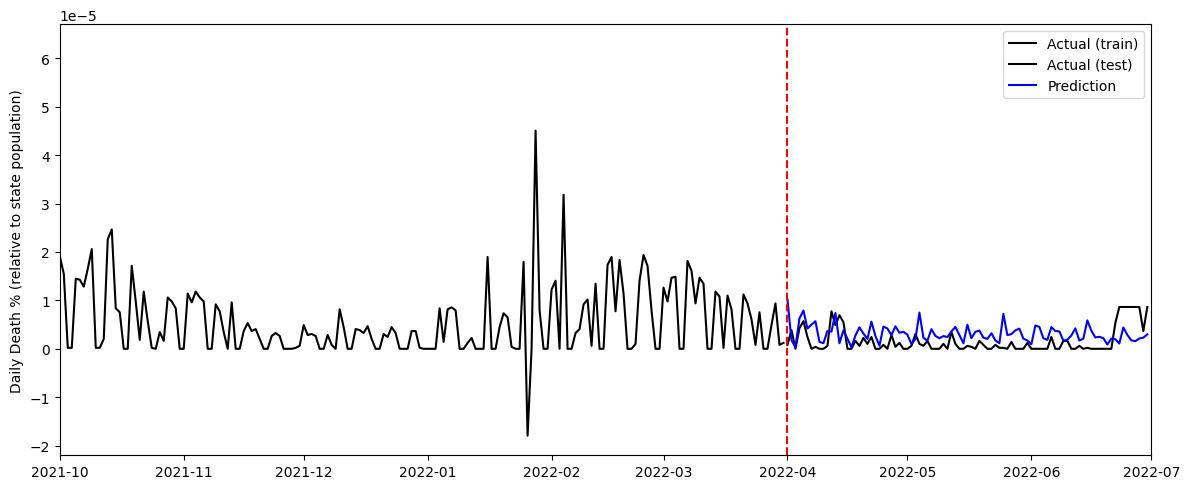

In [ ]:
y_pred = lgbmr_forecaster.predict(steps=len(X_AL_test), exog=X_AL_test)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(y_AL, color='black', label='Actual (train)')
ax.plot(y_AL_test, color='black', label='Actual (test)')
ax.plot(y_pred, color='blue', label='Prediction')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--')

ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 7, 1)))

ax.set_ylabel('Daily Death % (relative to state population)')

plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
lgbmr_forecaster.get_feature_importances()

,feature,importance
0,lag_1,97
1,lag_2,70
2,lag_3,109
3,lag_4,58
4,lag_5,72
5,lag_6,86
6,lag_7,110
7,lag_8,87
8,lag_9,77
9,lag_10,63


In [ ]:
rf_forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=123, n_jobs=3),
    lags = 21,
    differentiation = None
)

rf_forecaster.fit(y=y_AL, exog=X_AL)
rf_forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_jobs=3, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
Transformer for y: None 
Transformer for exog: None 
Window size: 21 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['pct_pop_in_svi_ctgy_A', 'pct_pop_in_svi_ctgy_B', 'pct_pop_in_svi_ctgy_C', 'pct_pop_in_svi_ctgy_D', 'pct_pop_in_metro', 'pct_pop_in_nonmetro', 'pct_doses_admin_5plus', 'pct_doses_admin_12plus', 'pct_doses_admin_18plus', 'pct_doses_admin_65plus', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6'] 
Training range: [Timestamp('2020-12-13 00:00:00'), Timestamp('2022-03-31 00:00:00')] 
Training index type: DatetimeIndex 
Training in

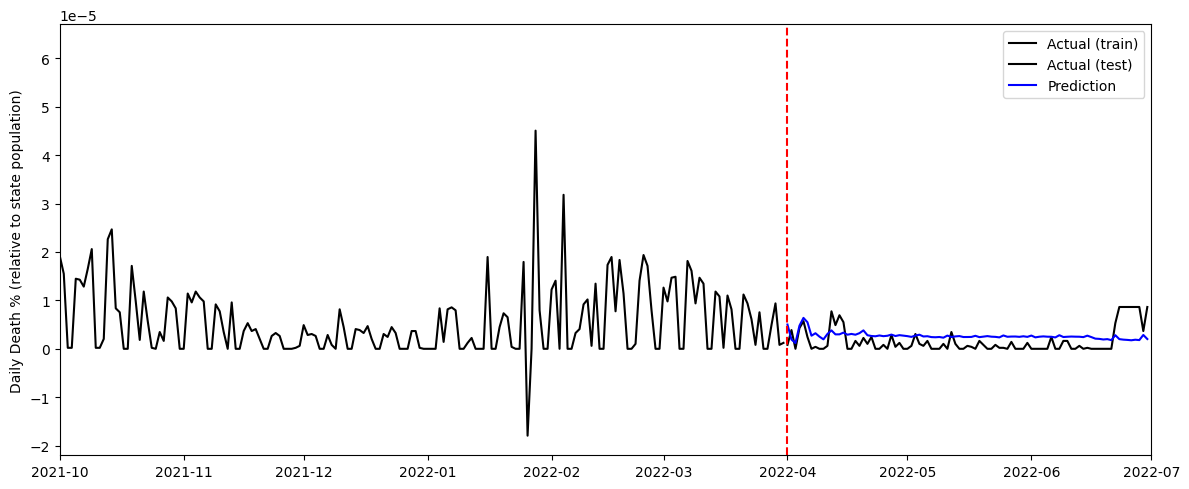

In [ ]:
y_pred = rf_forecaster.predict(steps=len(X_AL_test), exog=X_AL_test)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(y_AL, color='black', label='Actual (train)')
ax.plot(y_AL_test, color='black', label='Actual (test)')
ax.plot(y_pred, color='blue', label='Prediction')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--')

ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 7, 1)))

ax.set_ylabel('Daily Death % (relative to state population)')

plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
rf_forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.089166
1,lag_2,0.045710
2,lag_3,0.032617
3,lag_4,0.023804
4,lag_5,0.016480
5,lag_6,0.109264
6,lag_7,0.250680
7,lag_8,0.024381
8,lag_9,0.027417
9,lag_10,0.007886


# Helper Functions

In [67]:
def get_X_for_entity(entity_idx, varname, data=X_tr_phase1, use_death=False):

    out = data.loc[data[varname] == entity_idx, :].set_index('date')
    out = out.asfreq('D')
    if use_death:
        drop_cols = [varname]
    else:
        drop_cols = [varname, 'daily_death_pct']
    out = out.drop(columns=drop_cols)

    return out

def get_y_for_entity(entity_idx, varname, data=y_tr_phase1):

    out = data.loc[data[varname] == entity_idx, :].set_index('date')
    out = out.asfreq('D')
    out = out.drop(columns=varname).squeeze()

    return out

def get_data_for_state(entity_idx, varname, use_death):
    
    X_tr_1 = get_X_for_entity(entity_idx, varname, data=X_tr_phase1, use_death=use_death)
    X_te_1 = get_X_for_entity(entity_idx, varname, data=X_te_phase1, use_death=use_death)
    y_tr_1 = get_y_for_entity(entity_idx, varname, data=y_tr_phase1)
    y_te_1 = get_y_for_entity(entity_idx, varname, data=y_te_phase1)

    X_tr_2 = get_X_for_entity(entity_idx, varname, data=X_tr_phase2, use_death=use_death)
    X_te_2 = get_X_for_entity(entity_idx, varname, data=X_te_phase2, use_death=use_death)
    y_tr_2 = get_y_for_entity(entity_idx, varname, data=y_tr_phase2)
    y_te_2 = get_y_for_entity(entity_idx, varname, data=y_te_phase2)

    X_te_concat = pd.concat([X_te_1, X_te_2], axis=0)
    y_te_concat = pd.concat([y_te_1, y_te_2], axis=0)
    y_full      = pd.concat([y_tr_2, y_te_2], axis=0)

    return (X_tr_1, X_te_1, y_tr_1, y_te_1,
            X_tr_2, X_te_2, y_tr_2, y_te_2,
            X_te_concat, y_te_concat, y_full)

def get_data_for_county(entity_idx, varname, use_death):
    
    X_tr_1 = get_X_for_entity(entity_idx, varname, data=X_tr_phase1_county, use_death=use_death)
    X_te_1 = get_X_for_entity(entity_idx, varname, data=X_te_phase1_county, use_death=use_death)
    y_tr_1 = get_y_for_entity(entity_idx, varname, data=y_tr_phase1_county)
    y_te_1 = get_y_for_entity(entity_idx, varname, data=y_te_phase1_county)

    X_tr_2 = get_X_for_entity(entity_idx, varname, data=X_tr_phase2_county, use_death=use_death)
    X_te_2 = get_X_for_entity(entity_idx, varname, data=X_te_phase2_county, use_death=use_death)
    y_tr_2 = get_y_for_entity(entity_idx, varname, data=y_tr_phase2_county)
    y_te_2 = get_y_for_entity(entity_idx, varname, data=y_te_phase2_county)

    X_te_concat = pd.concat([X_te_1, X_te_2], axis=0)
    y_te_concat = pd.concat([y_te_1, y_te_2], axis=0)
    y_full      = pd.concat([y_tr_2, y_te_2], axis=0)

    return (X_tr_1, X_te_1, y_tr_1, y_te_1,
            X_tr_2, X_te_2, y_tr_2, y_te_2,
            X_te_concat, y_te_concat, y_full)

def forecast_national(fcster, level='state', use_death=False):

    models              = {}
    phase_1_pred        = {}
    phase_1_feat_imp    = {}
    phase_1_mse         = {}
    phase_1_r2          = {}
    phase_2_pred        = {}
    phase_2_feat_imp    = {}
    phase_2_mse         = {}
    phase_2_r2          = {}
    concat_pred         = {}
    ground_truth        = {}

    if level == 'state':
        iterator = STATES
        varname = 'recip_state'
    else:
        iterator = FIPS_LIST
        varname = 'fips'
    
    for entity_idx in blue_tqdm(iterator):

        if level == 'state':
            (X_tr_1, X_te_1, y_tr_1, y_te_1,
             X_tr_2, X_te_2, y_tr_2, y_te_2,
             X_te_concat, y_te_concat, y_full) = get_data_for_state(entity_idx, varname, use_death)

        else:
            (X_tr_1, X_te_1, y_tr_1, y_te_1,
             X_tr_2, X_te_2, y_tr_2, y_te_2,
             X_te_concat, y_te_concat, y_full) = get_data_for_county(entity_idx, varname, use_death)

        # Deep copies of forecasters to avoid state issues
        f1 = copy.deepcopy(fcster)
        f2 = copy.deepcopy(fcster)

        # Fit forecasters and add to models dict
        f1.fit(y=y_tr_1, exog=X_tr_1)
        f2.fit(y=y_tr_2, exog=X_tr_2)
        models[entity_idx] = (f1, f2)

        # Phase 1
        phase_1_pred[entity_idx]      = f1.predict(steps=len(X_te_1), exog=X_te_1)
        phase_1_feat_imp[entity_idx]  = f1.get_feature_importances()
        phase_1_mse[entity_idx]       = mean_squared_error(y_te_1, phase_1_pred[entity_idx])
        phase_1_r2[entity_idx]        = r2_score(y_te_1, phase_1_pred[entity_idx])

        # Phase 2
        phase_2_pred[entity_idx]      = f2.predict(steps=len(X_te_2), exog=X_te_2)
        phase_2_feat_imp[entity_idx]  = f2.get_feature_importances()
        phase_2_mse[entity_idx]       = mean_squared_error(y_te_2, phase_2_pred[entity_idx])
        phase_2_r2[entity_idx]        = r2_score(y_te_2, phase_2_pred[entity_idx])

        # Concatenated phases (for plotting)
        concat_pred[entity_idx]       = f1.predict(steps=len(X_te_concat), exog=X_te_concat)
        ground_truth[entity_idx]      = y_full


    pkg = (phase_1_pred, phase_1_feat_imp, phase_1_mse, phase_1_r2,
           phase_2_pred, phase_2_feat_imp, phase_2_mse, phase_2_r2,
           concat_pred, ground_truth, models)

    return pkg

def validate(pkg):
    
    (phase_1_pred, phase_1_feat_imp, phase_1_mse, phase_1_r2,
     phase_2_pred, phase_2_feat_imp, phase_2_mse, phase_2_r2,
     concat_pred, ground_truth, models) = pkg

    phase_1_pred_natl = pd.DataFrame(phase_1_pred).sum(axis=1)
    phase_2_pred_natl = pd.DataFrame(phase_2_pred).sum(axis=1)
    concat_pred_natl  = pd.DataFrame(concat_pred).sum(axis=1)
    ground_truth_natl = pd.DataFrame(ground_truth).sum(axis=1)
    
    pred_natl = pd.DataFrame({
        'Phase 1 (ext)':  concat_pred_natl,
        'Phase 2':        phase_2_pred_natl,
        'Actual':         ground_truth_natl
        })

    # Phase 1
    ## Ground Truth
    ph1_ground_truth_1m = ground_truth_natl[(ground_truth_natl.index >= datetime(2022, 4, 1)) & (ground_truth_natl.index < datetime(2022, 5, 1))]
    ph1_ground_truth_3m = ground_truth_natl[(ground_truth_natl.index >= datetime(2022, 4, 1)) & (ground_truth_natl.index < datetime(2022, 7, 1))]
    
    ## Predictions
    ph1_pred_1m = phase_1_pred_natl[(phase_1_pred_natl.index >= datetime(2022, 4, 1)) & (phase_1_pred_natl.index < datetime(2022, 5, 1))]
    ph1_pred_3m = phase_1_pred_natl
    
    # Phase 2
    ## Ground Truth
    ph2_ground_truth_1m = ground_truth_natl[(ground_truth_natl.index >= datetime(2022, 7, 1)) & (ground_truth_natl.index < datetime(2022, 8, 1))]
    ph2_ground_truth_3m = ground_truth_natl[(ground_truth_natl.index >= datetime(2022, 7, 1)) & (ground_truth_natl.index < datetime(2022, 10, 1))]
    
    ## Predictions
    ph2_pred_1m = phase_2_pred_natl[(phase_2_pred_natl.index >= datetime(2022, 7, 1)) & (phase_2_pred_natl.index < datetime(2022, 8, 1))]
    ph2_pred_3m = phase_2_pred_natl

    # Metrics 
    metrics = {}

    ## R2
    metrics['ph1_r2_1m'] = r2_score(ph1_ground_truth_1m, ph1_pred_1m)
    metrics['ph1_r2_3m'] = r2_score(ph1_ground_truth_3m, ph1_pred_3m)
    metrics['ph2_r2_1m'] = r2_score(ph2_ground_truth_1m, ph2_pred_1m)
    metrics['ph2_r2_3m'] = r2_score(ph2_ground_truth_3m, ph2_pred_3m)

    ## RMSE
    metrics['ph1_rmse_1m'] = math.sqrt(mean_squared_error(ph1_ground_truth_1m, ph1_pred_1m))
    metrics['ph1_rmse_3m'] = math.sqrt(mean_squared_error(ph1_ground_truth_3m, ph1_pred_3m))
    metrics['ph2_rmse_1m'] = math.sqrt(mean_squared_error(ph2_ground_truth_1m, ph2_pred_1m))
    metrics['ph2_rmse_3m'] = math.sqrt(mean_squared_error(ph2_ground_truth_3m, ph2_pred_3m))

    # MAE
    metrics['ph1_mae_1m'] = mean_absolute_error(ph1_ground_truth_1m, ph1_pred_1m)
    metrics['ph1_mae_3m'] = mean_absolute_error(ph1_ground_truth_3m, ph1_pred_3m)
    metrics['ph2_mae_1m'] = mean_absolute_error(ph2_ground_truth_1m, ph2_pred_1m)
    metrics['ph2_mae_3m'] = mean_absolute_error(ph2_ground_truth_3m, ph2_pred_3m)

    return metrics, pred_natl

In [49]:
def plot_national(pred_natl, fname):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(pred_natl['Actual'], color='black', label='Actual')
    
    ax.plot(pred_natl['Phase 1 (ext)'], color='blue', label='Prediction (Phase 1 Model)')
    ax.plot(pred_natl['Phase 2'], color='green', label='Prediction (Phase 2 Model)')
    
    vline_1 = datetime(2022, 4, 1)
    vline_2 = datetime(2022, 7, 1)
    ax.axvline(x=vline_1, color='red', linestyle='--')
    ax.axvline(x=vline_2, color='red', linestyle='--')
    
    ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 10, 1)))
    ax.set_ylim((0, 6_000))
    
    ax.set_ylabel('Daily Deaths')
    plt.title('COVID-19 Mortality Prediction at National Level (LightGBM)')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(os.path.join(VIZ_PATH, 'predictions', f'{fname}.png'))
    
    plt.show()

# Experiments

In [23]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [24]:
experiment_description = (
    "This is an experiment forecasting national COVID deaths using timeseries methods."
)

experiment_tags = {
    "project_name": "covid-deaths-fcst",
    "team": "opai",
    "mlflow.note.content": experiment_description,
}

covid_lgbm_exp = client.create_experiment(name="covid-deaths-lgbm", tags=experiment_tags)

In [55]:
def run_lgbm_experiment(config):
    
    my_forecaster = ForecasterAutoreg(
        regressor = LGBMRegressor(random_state=123, n_jobs=6, verbose=-1),
        lags = config['lags'],
        differentiation = None
    )
    pkg = forecast_national(my_forecaster, level=config['level'], use_death=config['use_death'])
    metrics, pred_natl = validate(pkg)
    print(metrics)
    
    # ML FLow Logging -------------------------------------------------------------
    mlflow.set_tracking_uri("http://127.0.0.1:8080")
    lgbm_exp = mlflow.set_experiment('covid-deaths-lgbm')
    
    lags_str = str(config['lags'])
    use_death_str = 'usedeath' if config['use_death'] else 'nodeath'
    level_str = 'state' if config['level'] == 'state' else 'county'
    
    run_name = f'lgbm-{lags_str}-{use_death_str}-{level_str}'
    artifact_path = f'lgbm-{lags_str}-{use_death_str}-{level_str}-atfc'
    
    with mlflow.start_run(run_name=run_name) as run:
        mlflow.log_params(config)
        mlflow.log_metrics(metrics)

    plot_national(pred_natl, run_name)

## State-Level

### lgbm-14-state-nodeath

  0%|          | 0/52 [00:00<?, ?it/s]

{'ph1_r2_1m': -0.6176818402092079, 'ph1_r2_3m': -1.2768808238838387, 'ph2_r2_1m': 0.6051423975375785, 'ph2_r2_3m': 0.4788829150713705, 'ph1_rmse_1m': 645.4488707289876, 'ph1_rmse_3m': 725.7490976440871, 'ph2_rmse_1m': 449.16338027743166, 'ph2_rmse_3m': 708.169823444621, 'ph1_mae_1m': 520.1410263210054, 'ph1_mae_3m': 627.6190385400498, 'ph2_mae_1m': 322.055607092422, 'ph2_mae_3m': 547.9125574058941}


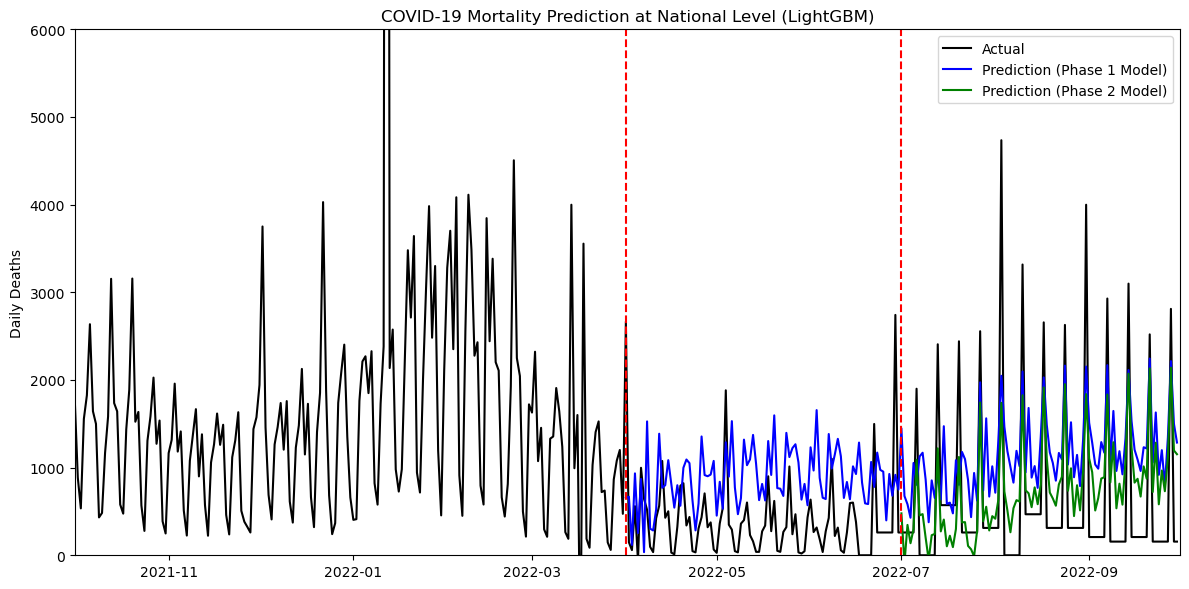

In [65]:
config = {
    'lags': 14,
    'use_death': False,
    'level': 'state',
}
run_lgbm_experiment(config)

### lgbm-14-state-usedeath

  0%|          | 0/52 [00:00<?, ?it/s]

{'ph1_r2_1m': -0.30542980724103264, 'ph1_r2_3m': -1.8232643369237946, 'ph2_r2_1m': -14.530771941963703, 'ph2_r2_3m': -7.0120242589162025, 'ph1_rmse_1m': 579.8184793625709, 'ph1_rmse_3m': 808.1502766154783, 'ph2_rmse_1m': 2816.959549225648, 'ph2_rmse_3m': 2776.7762653498858, 'ph1_mae_1m': 291.1010914666509, 'ph1_mae_3m': 406.76402988872604, 'ph2_mae_1m': 2003.7385924330745, 'ph2_mae_3m': 2185.0017345411184}


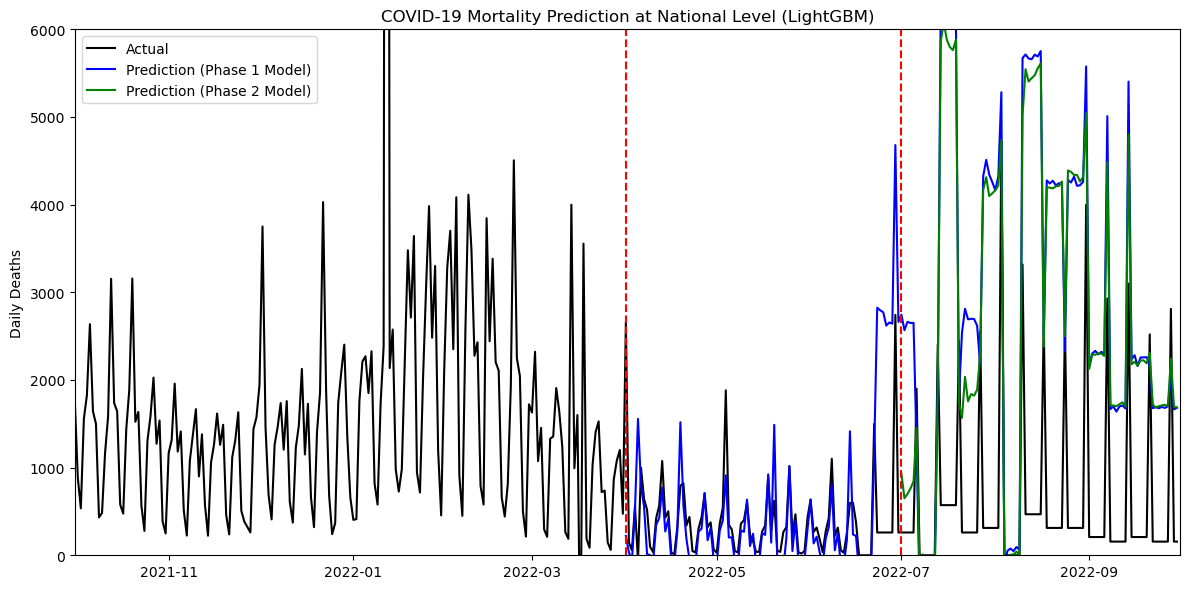

In [58]:
config = {
    'lags': 14,
    'use_death': True,
    'level': 'state',
}
run_lgbm_experiment(config)

### lgbm-21-state-nodeath

  0%|          | 0/52 [00:00<?, ?it/s]

{'ph1_r2_1m': -1.0645631969975837, 'ph1_r2_3m': -2.628479376624594, 'ph2_r2_1m': 0.604901689880541, 'ph2_r2_3m': 0.4859645554884525, 'ph1_rmse_1m': 729.1709881425049, 'ph1_rmse_3m': 916.1755220282449, 'ph2_rmse_1m': 449.30026581797915, 'ph2_rmse_3m': 703.3415817655642, 'ph1_mae_1m': 586.913576993199, 'ph1_mae_3m': 810.0864911285086, 'ph2_mae_1m': 331.19578301101313, 'ph2_mae_3m': 559.2578185566484}


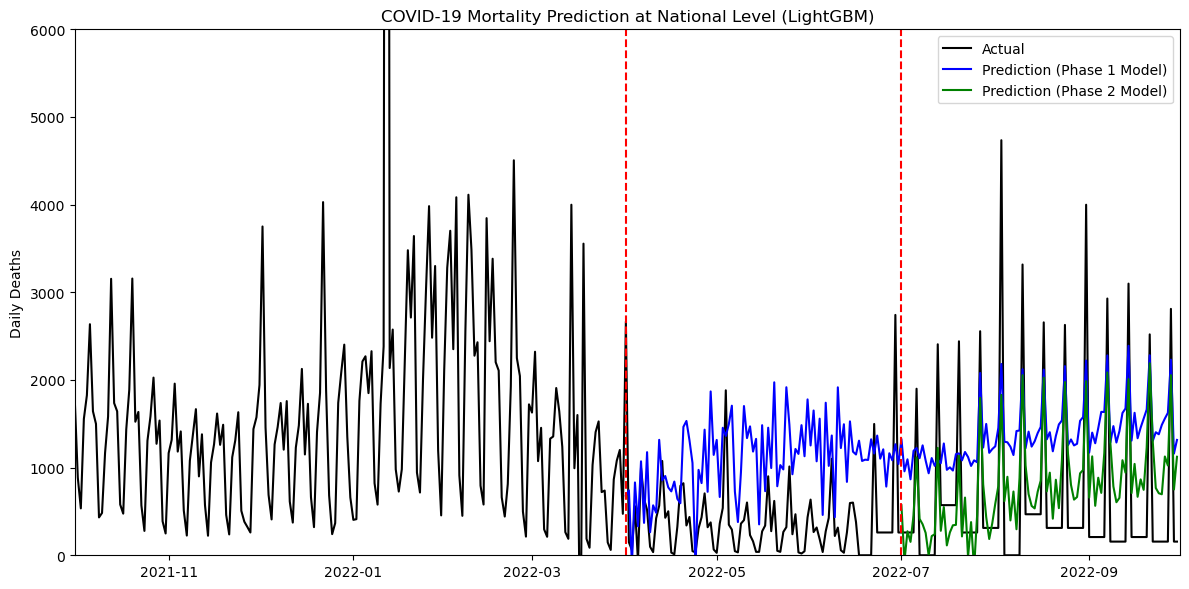

In [59]:
config = {
    'lags': 21,
    'use_death': False,
    'level': 'state',
}
run_lgbm_experiment(config)

### lgbm-21-state-usedeath

  0%|          | 0/52 [00:00<?, ?it/s]

{'ph1_r2_1m': -0.4827265884677663, 'ph1_r2_3m': -1.972278454475692, 'ph2_r2_1m': -14.240435284874955, 'ph2_r2_3m': -7.18669852927251, 'ph1_rmse_1m': 617.9393161689835, 'ph1_rmse_3m': 829.2034521620026, 'ph2_rmse_1m': 2790.504807294425, 'ph2_rmse_3m': 2806.8820275342587, 'ph1_mae_1m': 329.5165775381304, 'ph1_mae_3m': 435.92376956464585, 'ph2_mae_1m': 1978.073922371944, 'ph2_mae_3m': 2220.2712551624513}


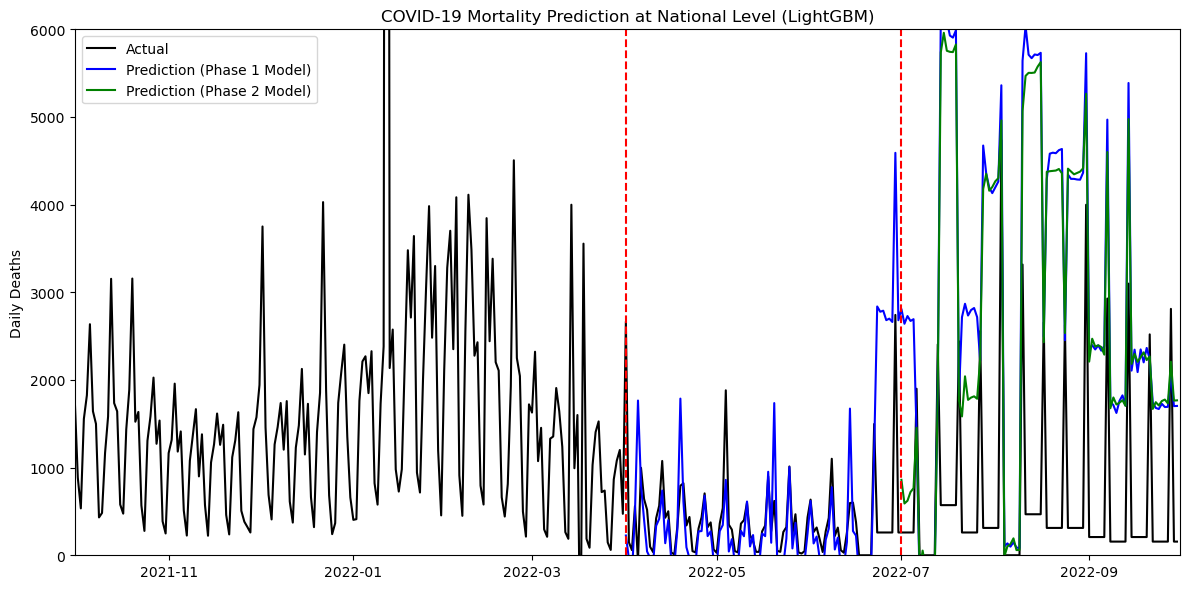

In [60]:
config = {
    'lags': 21,
    'use_death': True,
    'level': 'state',
}
run_lgbm_experiment(config)

### lgbm-28-state-nodeath

  0%|          | 0/52 [00:00<?, ?it/s]

{'ph1_r2_1m': -1.2802350210505256, 'ph1_r2_3m': -3.3323690704038214, 'ph2_r2_1m': 0.6279472037113367, 'ph2_r2_3m': 0.35621413061424345, 'ph1_rmse_1m': 766.3110640082232, 'ph1_rmse_3m': 1001.103726837312, 'ph2_rmse_1m': 435.9998862269221, 'ph2_rmse_3m': 787.1191539241859, 'ph1_mae_1m': 641.6368131892006, 'ph1_mae_3m': 868.7403112768816, 'ph2_mae_1m': 313.67009441457856, 'ph2_mae_3m': 623.9878291841953}


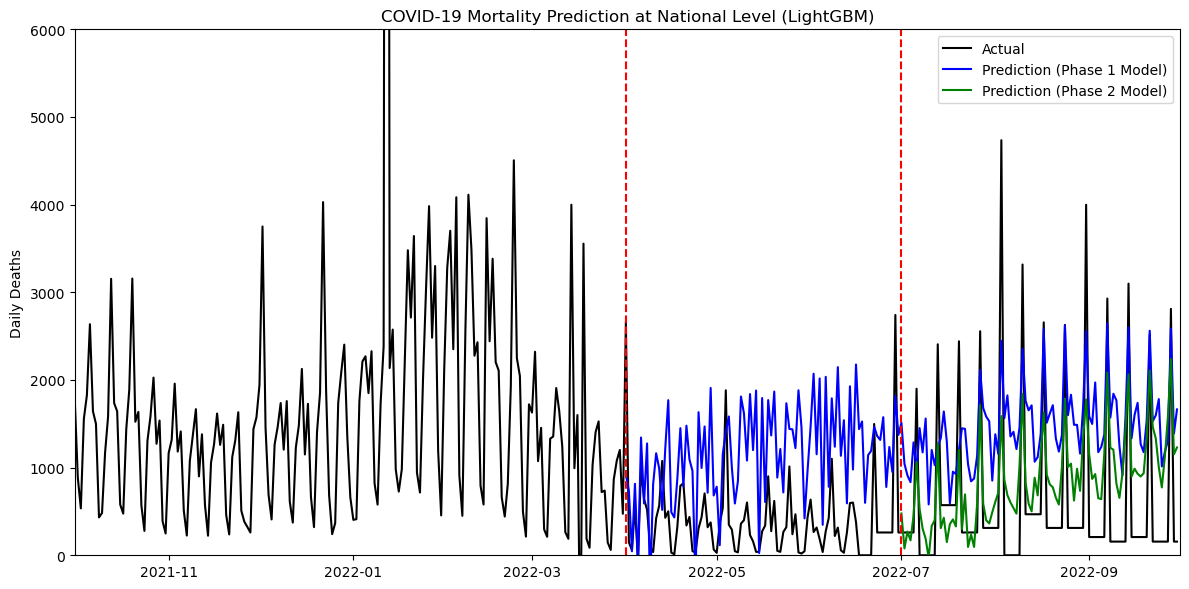

In [61]:
config = {
    'lags': 28,
    'use_death': False,
    'level': 'state',
}
run_lgbm_experiment(config)

### lgbm-28-state-usedeath

  0%|          | 0/52 [00:00<?, ?it/s]

{'ph1_r2_1m': -0.26236577700700137, 'ph1_r2_3m': -1.7154129160786962, 'ph2_r2_1m': -13.49399835559848, 'ph2_r2_3m': -6.917902976968831, 'ph1_rmse_1m': 570.1746390484997, 'ph1_rmse_3m': 792.5639136512101, 'ph2_rmse_1m': 2721.3111011993933, 'ph2_rmse_3m': 2760.4179869267764, 'ph1_mae_1m': 305.34885523746806, 'ph1_mae_3m': 414.25459846757, 'ph2_mae_1m': 1912.6068313873648, 'ph2_mae_3m': 2162.782942483797}


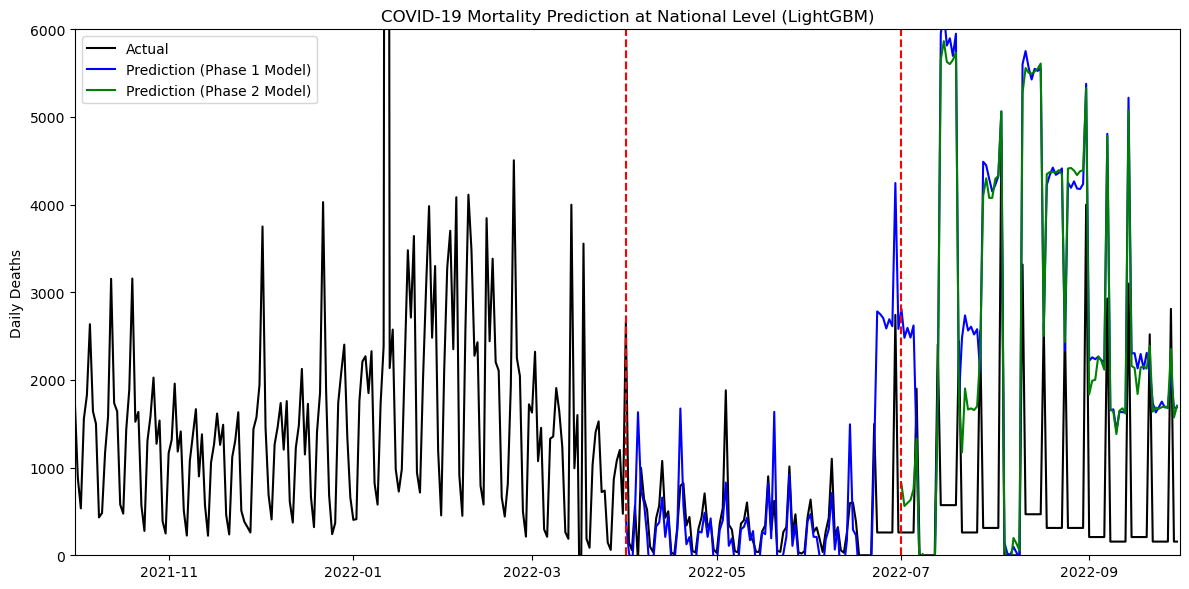

In [62]:
config = {
    'lags': 28,
    'use_death': True,
    'level': 'state',
}
run_lgbm_experiment(config)

## County-Level Experiments

### lgbm-14-county-nodeath

  0%|          | 0/3219 [00:00<?, ?it/s]

{'ph1_r2_1m': -0.1767856821208802, 'ph1_r2_3m': -2.9692100923049782, 'ph2_r2_1m': 0.06909275353520661, 'ph2_r2_3m': -0.5423106323639388, 'ph1_rmse_1m': 550.5120456564578, 'ph1_rmse_3m': 979.3248217991469, 'ph2_rmse_1m': 757.9018396649107, 'ph2_rmse_3m': 1308.0323671126168, 'ph1_mae_1m': 419.1484571127179, 'ph1_mae_3m': 735.1183539946592, 'ph2_mae_1m': 658.9563036376514, 'ph2_mae_3m': 1192.2991254316244}


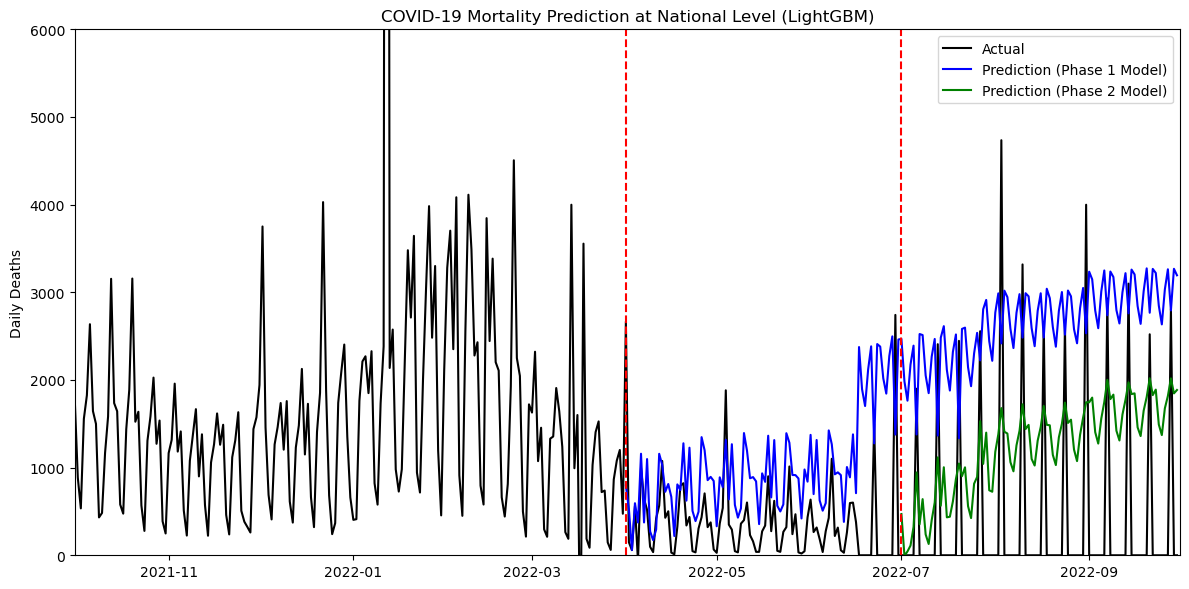

In [68]:
config = {
    'lags': 14,
    'use_death': False,
    'level': 'county',
}
run_lgbm_experiment(config)

### lgbm-21-county-nodeath

  0%|          | 0/3219 [00:01<?, ?it/s]

{'ph1_r2_1m': -0.5993216894992968, 'ph1_r2_3m': -4.086011609077557, 'ph2_r2_1m': -0.010771157116162833, 'ph2_r2_3m': -0.8464262101524203, 'ph1_rmse_1m': 641.7798121617868, 'ph1_rmse_3m': 1108.5706910129602, 'ph2_rmse_1m': 789.7437107895869, 'ph2_rmse_3m': 1431.1941177620547, 'ph1_mae_1m': 522.9071823838392, 'ph1_mae_3m': 898.8830023119717, 'ph2_mae_1m': 678.0523373286554, 'ph2_mae_3m': 1292.4685543842313}


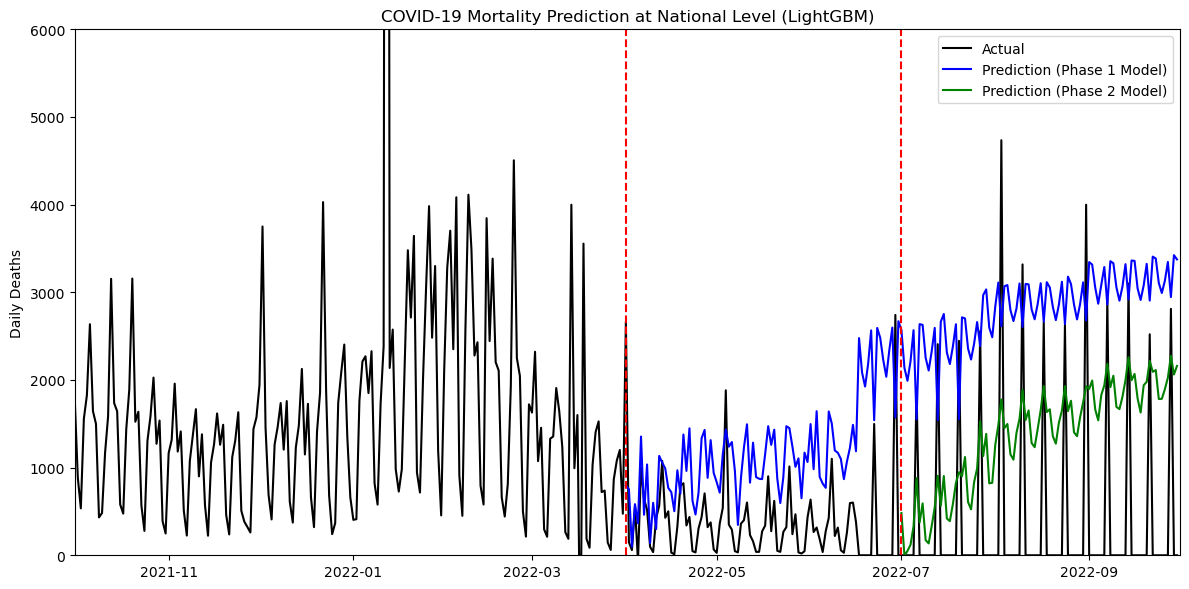

In [69]:
config = {
    'lags': 21,
    'use_death': False,
    'level': 'county',
}
run_lgbm_experiment(config)